In [29]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [30]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value', 'op code']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [25]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}

# Training models for each department using CatBoost
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model
    department_model = CatBoostRegressor(
        iterations=1500,
        early_stopping_rounds=100,
        loss_function='MAE',
        verbose=True
    )
    department_model.fit(
        X_train_dept, y_train_dept,
        eval_set=(X_test_dept, y_test_dept)
    )
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)

# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

print(f"Ensemble MAE: {mae_dt}, RMSE: {rmse_dt}, R²: {r2_dt}")


0:	learn: 74.6420266	test: 72.5447769	best: 72.5447769 (0)	total: 142ms	remaining: 3m 33s
1:	learn: 73.5810241	test: 71.5210626	best: 71.5210626 (1)	total: 147ms	remaining: 1m 49s
2:	learn: 72.3584111	test: 70.3520530	best: 70.3520530 (2)	total: 152ms	remaining: 1m 15s
3:	learn: 71.2092983	test: 69.2599414	best: 69.2599414 (3)	total: 156ms	remaining: 58.4s
4:	learn: 70.1237686	test: 68.2358154	best: 68.2358154 (4)	total: 160ms	remaining: 47.9s
5:	learn: 69.0696643	test: 67.2241166	best: 67.2241166 (5)	total: 165ms	remaining: 41s
6:	learn: 68.1650154	test: 66.3528665	best: 66.3528665 (6)	total: 170ms	remaining: 36.2s
7:	learn: 67.3515901	test: 65.5868222	best: 65.5868222 (7)	total: 173ms	remaining: 32.3s
8:	learn: 66.5701828	test: 64.8384636	best: 64.8384636 (8)	total: 177ms	remaining: 29.4s
9:	learn: 65.8109234	test: 64.1200476	best: 64.1200476 (9)	total: 182ms	remaining: 27.2s
10:	learn: 65.0945982	test: 63.4518233	best: 63.4518233 (10)	total: 187ms	remaining: 25.3s
11:	learn: 64.3737

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score


cross_val_scores = {}

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}


# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with cross-validation
    department_model = DecisionTreeRegressor(random_state=42)
    cv_scores = cross_val_score(department_model, X_dept, y_dept, cv=5)
    cross_val_scores[dept] = cv_scores.mean()

    # Training and saving the final model
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)


# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_dt, rmse_dt, r2_dt, cross_val_scores

(8.728817764545342,
 33.966907974749354,
 0.9031280218239416,
 {'General Surgery': 0.4374586315725086,
  'Otolaryngology': 0.05612990560109341,
  'Orthopedics': 0.18118732008686508,
  'Ophthalmology': 0.16619732538008256,
  'Obstetrics & Gynecology': 0.19049951860142875,
  'Urology': 0.531179447931976,
  'Plastic Surgery': 0.3726819872315882,
  'Neurosurgery': 0.24676262452756773,
  'Cardiovascular Thoracic Surgery': 0.5511886401771632,
  'Pediatric Otolaryngology': 0.306515719537049,
  'Pediatric Orthopedics': -0.09006979107344563,
  'Pediatric Thoracic Surgery': 0.5836053320794976,
  'Pediatric Urology': 0.1188294632815415,
  'Pediatric Surgery': 0.016342935490812383,
  'Pediatric Ophthalmology': -0.17455940119684416,
  'Pediatric Plastic Surgery': -0.6147159240393567,
  'Pediatric Neurosurgery': 0.04444055949996813})

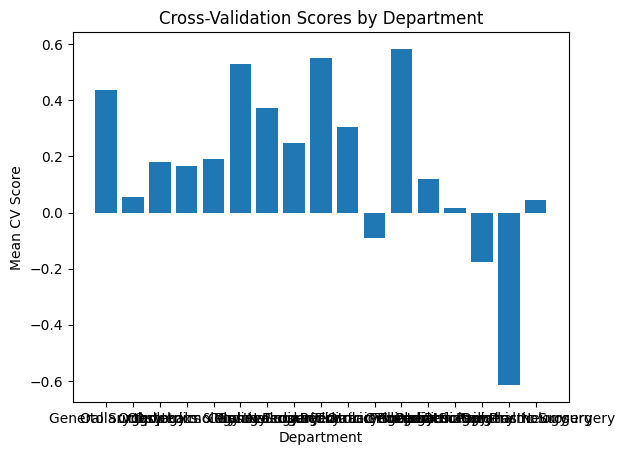

In [40]:
import matplotlib.pyplot as plt

# 각 부서별 교차 검증 점수를 막대 그래프로 표시
departments = list(cross_val_scores.keys())
cv_scores = list(cross_val_scores.values())

plt.bar(departments, cv_scores)
plt.xlabel('Department')
plt.ylabel('Mean CV Score')
plt.title('Cross-Validation Scores by Department')
plt.show()


In [41]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


<module 'matplotlib.pyplot' from 'c:\\Users\\Roh\\Documents\\GitHub\\Surgical-Duration-Prediction\\surgical\\lib\\site-packages\\matplotlib\\pyplot.py'>

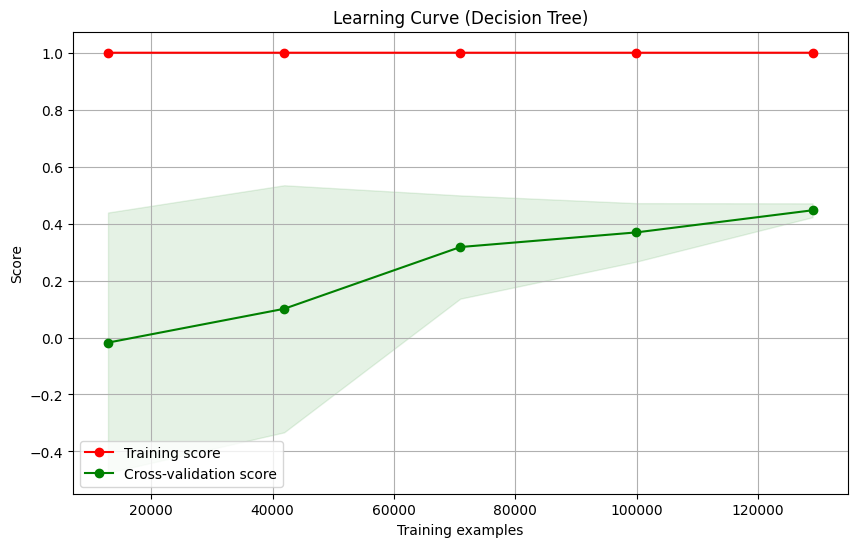

In [45]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# 학습 곡선 그리기
X = df_encoded.drop('surgery duration', axis=1)
y = df_encoded['surgery duration']
estimator = DecisionTreeRegressor(random_state=42) # 또는 다른 모델
plot_learning_curve(estimator, "Learning Curve (Decision Tree)", X, y, cv=5)


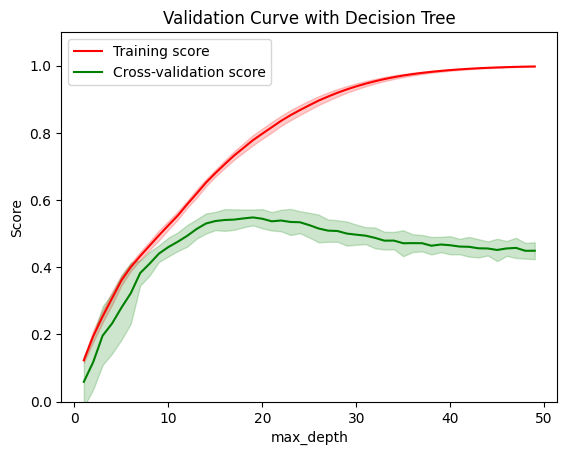

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve

# 데이터 준비
X = df_encoded.drop('surgery duration', axis=1)
y = df_encoded['surgery duration']

# 검증 곡선을 위한 하이퍼파라미터 범위 설정
param_range = np.arange(1, 51, 1)

# 검증 곡선 계산
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42),
    X, y,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1)

# 평균과 표준 편차 계산
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 검증 곡선 그리기
plt.title("Validation Curve with Decision Tree")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, label="Training score",
         color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
         color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [48]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve

# 데이터 준비
X = df_encoded.drop('surgery duration', axis=1)
y = df_encoded['surgery duration']

# 검증 곡선을 위한 하이퍼파라미터 범위 설정
param_range = np.arange(1, 51, 1)

# 검증 곡선 계산
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42),
    X, y,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1)

# 교차 검증 점수의 평균 계산
test_scores_mean = np.mean(test_scores, axis=1)

# 최적의 max_depth 찾기
optimal_max_depth = param_range[test_scores_mean.argmax()]
print(f"최적의 max_depth: {optimal_max_depth}")

최적의 max_depth: 19


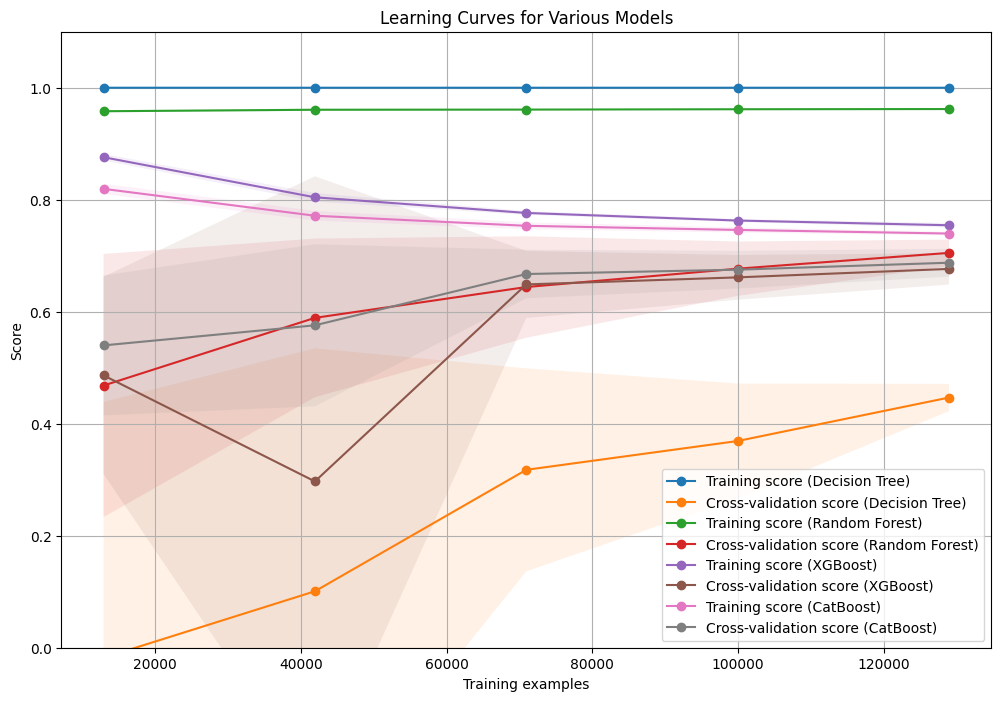

In [50]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f"Training score ({title})")
    plt.plot(train_sizes, test_scores_mean, 'o-', label=f"Cross-validation score ({title})")

# 데이터 준비
X = df_encoded.drop('surgery duration', axis=1)
y = df_encoded['surgery duration']

# 모델 설정
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# 그래프 설정
plt.figure(figsize=(12, 8))
plt.title("Learning Curves for Various Models")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)

# 각 모델의 학습 곡선 그리기
for name, estimator in models.items():
    plot_learning_curve(estimator, name, X, y, cv=5)

plt.legend(loc="best")
plt.grid()
plt.show()
